In [3]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO
%matplotlib inline

import lightgbm as lgb
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold


from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [5]:
# 効率的に前処理を行うためtrainデータとtestデータをいったん結合する
df_train_test = pd.concat([df_train, df_test], ignore_index=True, sort=False)

In [6]:
print(df_train_test.isnull().sum())

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


In [7]:
df_train_test['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [8]:
# Sを補完
df_train_test['Embarked'] = df_train_test['Embarked'].fillna('S')

In [9]:
# 確認
df_train_test['Embarked'].value_counts()

S    916
C    270
Q    123
Name: Embarked, dtype: int64

In [10]:
# Fareが欠損値であるレコードの抽出
df_train_test[df_train_test['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [11]:
df_train_test.groupby('Pclass').median()
# Pclass=3のFareの中央値は8

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,670,1.0,39.0,0,0,60.0000
2,671,0.0,29.0,0,0,15.0458
3,644,0.0,24.0,0,0,8.0500


In [12]:
df_train_test.groupby('Pclass').mean()
# Pclass=3のFareの平均値は13

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,672.492260,0.629630,39.159930,0.436533,0.365325,87.508992
2,671.566787,0.472826,29.506705,0.393502,0.368231,21.179196
3,640.558533,0.242363,24.816367,0.568406,0.400564,13.302889


In [13]:
# Fareが欠損値のレコードのPclassは3なのでその中央値8を補完する
# df_train_test['Fare'] = df_train_test['Fare'].fillna(8)

# Pclassが3のときのFareの中央値を補完
df_train_test['Fare'] = df_train_test['Fare'].fillna(df_train_test.query('Pclass==3')['Fare'].median())

In [14]:
# Pclass毎に年齢の欠損値補完

Age_fillna1 = df_train_test.query('Pclass==1')['Age'].median()
Age_fillna2 = df_train_test.query('Pclass==2')['Age'].median()
Age_fillna3 = df_train_test.query('Pclass==3')['Age'].median()

In [15]:
# 各行のAgeが欠損値のとき、Pclassが1の場合、2の場合、3の場合で欠損値補完を場合分け
# 欠損値であるかどうかの判定にはpandas.isnull()を使う。numpy.isnan(), math.isnan()でもいい 今回はnumpy.isnan()を使用
# 参考:https://note.nkmk.me/python-pandas-nan-dropna-fillna/
for i in range(len(df_train_test)):
    if np.isnan(df_train_test['Age'][i]):
        if df_train_test['Pclass'][i] == 1:
            df_train_test['Age'][i] = Age_fillna1
        elif df_train_test['Pclass'][i] == 2:
            df_train_test['Age'][i] = Age_fillna2
        else:
            df_train_test['Age'][i] = Age_fillna3  

C:\Users\Tomori kengo\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Tomori kengo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Tomori kengo\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [16]:
print(df_train_test.isnull().sum())

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
dtype: int64


In [17]:
df_train_test['Family'] = df_train_test['SibSp'] + df_train_test['Parch'] + 1

In [18]:
df_train_test = df_train_test.assign(
  Alone = (df_train_test['Family'] == 1).astype(int)
)

In [19]:
df_train_test = df_train_test.assign(
  Child = (df_train_test['Age'] < 21).astype(int)
)

In [20]:
df_train_test = df_train_test.drop(['Name', 'Ticket', 'Cabin'], axis=1)

In [21]:
df_train_test['Sex'] = pd.get_dummies(df_train_test['Sex'])
df_train_test['Embarked'] = pd.get_dummies(df_train_test['Embarked'])

In [22]:
# 前処理が完了
# 学習データと検証データに分割
df_train2 = df_train_test[df_train_test['PassengerId'] < 892]
df_test2 = df_train_test[df_train_test['PassengerId'] >= 892]

In [23]:
del df_train2['PassengerId']
del df_test2['PassengerId']

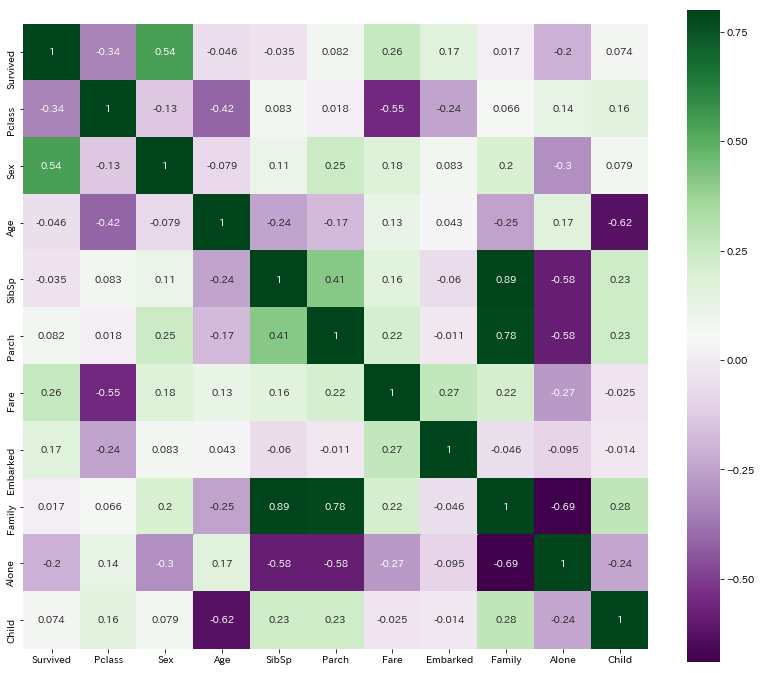

In [24]:
plt.figure(figsize=(14,12))
sns.heatmap(df_train2.corr(), vmax=.8, square=True, linecolor='white', cmap = 'PRGn', annot=True )

In [25]:
train_X = df_train2.drop(['Survived'], axis = 1)

In [26]:
train_y = df_train2['Survived']

In [27]:
# 今回は線形SVMを使用
# 線形SVMでは入力データを標準化(平均0,標準偏差1)する
sc = StandardScaler()

In [28]:
sc.fit(train_X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [29]:
train_X_std = sc.transform(train_X)

In [30]:
test_X = df_test2.drop(['Survived'], axis=1)

In [31]:
test_X_std = sc.transform(test_X)

In [33]:
# グリッドサーチ
# 参考:http://aiweeklynews.com/archives/50219779.html
parameters  = {'C': [1, 10, 100, 1000],  'gamma': [0.01, 0.001, 0.0001]}
model = GridSearchCV(SVC(), parameters, cv=5)

In [34]:
model.fit(train_X_std, train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [35]:
pred_y = model.predict(test_X_std)

In [36]:
pred_y[:10]

array([0., 1., 0., 0., 1., 0., 1., 0., 1., 0.])

In [37]:
output = pd.read_csv('test.csv')

In [38]:
output['Survived'] = pred_y

In [39]:
output[['PassengerId','Survived']].to_csv('submission_180925_1.csv', index=False)

In [ ]:
# score = 0.77033 Best Entry 
# 参考:http://d.hatena.ne.jp/knaka20blue/20180110